In [65]:
import os
import sys
import glob
import random
import warnings
import itertools
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import cv2  # pip install opencv-python
#from PIL import Image
#from PIL import ImageFont
#from PIL import ImageDraw
#from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, ElementTree
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score




#from pathlib import Path
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization ,Conv2D,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam,SGD
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import categorical_crossentropy,binary_crossentropy
from tensorflow.keras.callbacks import Callback,LearningRateScheduler
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [2]:
# 지갑, 키, 가방, 노트북

In [3]:
os.getcwd()

'C:\\Users\\User\\Desktop\\개인\\cap\\ml'

In [4]:
#import os
# import random
# from shutil import copyfile

# source_dir = './data/'  # Source directory with your data
# train_dir = './data/train/'  # Destination directory for training data
# test_dir = './data/test/'    # Destination directory for testing data

# # Create the train and test directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Define the ratio of data to be used for training
# train_ratio = 0.8  # 80% for training, 20% for testing
# CLASS_NAMES = ['key','wallet']
# # Iterate through your class names (e.g., "true" and "false")
# for class_name in CLASS_NAMES:
#     class_source_dir = os.path.join(source_dir, class_name)
#     class_train_dir = os.path.join(train_dir, class_name)
#     class_test_dir = os.path.join(test_dir, class_name)

#     # Create the class-specific train and test directories
#     os.makedirs(class_train_dir, exist_ok=True)
#     os.makedirs(class_test_dir, exist_ok=True)

#     # List all files in the source directory for the current class
#     file_list = os.listdir(class_source_dir)

#     # Shuffle the file list to randomly split the data
#     random.shuffle(file_list)

#     # Calculate the number of files for training and testing based on the ratio
#     num_files = len(file_list)
#     num_train_files = int(train_ratio * num_files)

#     # Move the files to the appropriate train and test directories
#     for i, file_name in enumerate(file_list):
#         source_file = os.path.join(class_source_dir, file_name)
#         if i < num_train_files:
#             destination_dir = class_train_dir
#         else:
#             destination_dir = class_test_dir
#         destination_file = os.path.join(destination_dir, file_name)

#         copyfile(source_file, destination_file)

# # Now your data is split into train and test directories


In [75]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16

image_generator = ImageDataGenerator(rescale=1./255)

base_dir = Path('./data')

train_dir = './data/train'


test_dir = './data/test'
BATCH_SIZE = 3
IMG_HEIGHT = 75
IMG_WIDTH = 75
image_count = len(list(base_dir.glob('*.jpg')))
print(image_count)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = ["key", "wallet", "bagpack", "laptop"]

# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(rescale=1./255,  # 이미지 값을 0과 1 사이로 스케일 조정
                             #shear_range=0.2,  # 전단 변환
                             #zoom_range=0.2,   # 확대/축소 변환
                             #horizontal_flip=True,  # 수평 뒤집기
                             validation_split=0.2)  # 검증 데이터의 비율을 20%로 설정

# 데이터를 읽어오고 나누기
train_data_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # 분류 문제인 경우 'categorical'로 설정
    subset='training')  # 학습 데이터로 사용할 부분

validation_data_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')  # 검증 데이터로 사용할 부분


test_data_generator = image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset=None)  # 테스트 데이터로 사용할 부분

0
Found 707 images belonging to 4 classes.
Found 175 images belonging to 4 classes.
Found 202 images belonging to 4 classes.


In [77]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Assuming you have 4 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjust the learning rate as needed
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 3, 3, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 128)               163968    
                                                                 
 dense_22 (Dense)            (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484 (642.52 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [80]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy',  # Monitor the validation accuracy
                               patience=5,  # Number of epochs with no improvement after which training will be stopped
                               mode='max',  # 'max' means training will stop when the quantity monitored has stopped increasing
                               verbose=1)  # Display a message when training is stopped

# 모델 훈련
history = model.fit(
    train_data_generator,
    epochs=10,  # You can set a large number of epochs, EarlyStopping will stop training when the condition is met
    validation_data=validation_data_generator,
    callbacks=[early_stopping]  # Add EarlyStopping callback to the training loop
)


Epoch 1/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0952 - accuracy: 0.9830 - val_loss: 0.3880 - val_accuracy: 0.8514
Epoch 2/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0885 - accuracy: 0.9830 - val_loss: 0.4046 - val_accuracy: 0.8571
Epoch 3/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0617 - accuracy: 0.9901 - val_loss: 0.4243 - val_accuracy: 0.8286
Epoch 4/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0470 - accuracy: 0.9958 - val_loss: 0.4161 - val_accuracy: 0.8286
Epoch 5/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0398 - accuracy: 0.9943 - val_loss: 0.3975 - val_accuracy: 0.8514
Epoch 6/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0348 - accuracy: 0.9958 - val_loss: 0.4007 - val_accuracy: 0.8514
Epoch 7/10
236/236 [==============================] - 3s 13ms/step - loss: 0.0270 - accuracy: 0.9986 - val_loss: 0.4598 - val_accuracy: 0.8286

In [81]:
test_loss, test_accuracy = model.evaluate(test_data_generator, verbose=2)

print(f"Test accuracy: {test_accuracy:.4f}")

68/68 - 1s - loss: 0.3376 - accuracy: 0.8911 - 640ms/epoch - 9ms/step
Test accuracy: 0.8911


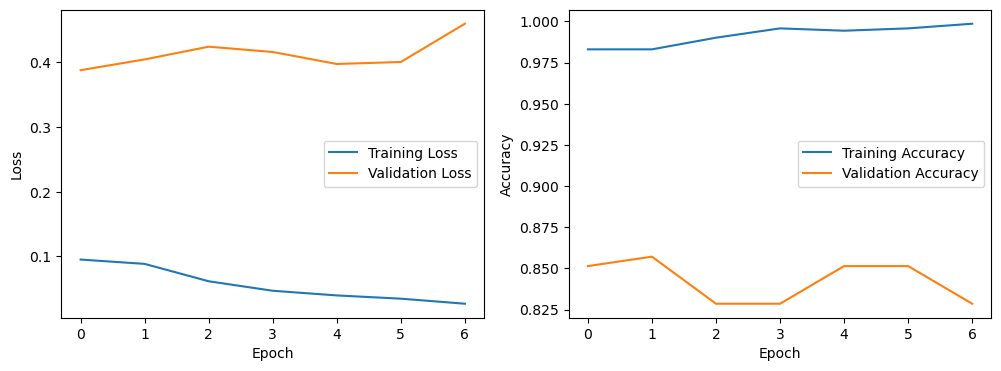

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [82]:
# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Calculate ROC curve and AUC
validation_data_gen.reset()
y_true = []
y_pred = []

for i in range(len(validation_data_gen)):
    x_val, y_val = validation_data_gen[i]
    y_true.extend(y_val)
    y_pred.extend(model.predict(x_val))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_true[:, 1], y_pred[:, 1])
pr_auc = average_precision_score(y_true[:, 1], y_pred[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()



In [83]:
model.save("capstone.h5")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(tf.__version__)

In [86]:
from tensorflow.keras.models import load_model
loaded_model = load_model('capstone.h5')  # Replace with the path to your saved model file

# Display the summary of the loaded model
loaded_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 3, 3, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 128)               163968    
                                                                 
 dense_22 (Dense)            (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484 (642.52 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
